In [1]:
import torch as tch
import torch.nn.functional as F
import torch.nn as tchnn
import torch.autograd as tchagd
import torch.optim as tchoptim
from torch.autograd import Variable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
import visdom

In [2]:
#params for the system
e_inp_dim = 28*28
e_out_dim = 100 #z, latent variable
d_inp_dim = 100
d_out_dim = 28*28
n_hidden = 512
n_iter = 1000
BATCHSZ = 64*2

In [3]:
#visdom client
vis = visdom.Visdom(port=7777)

In [4]:
#encoder network (X -> z)
class Encoder(tchnn.Module):
	def __init__(self):
		super(Encoder, self).__init__()
		self.L1 = tchnn.Linear(e_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, e_out_dim) #for mu and sigma 
		self.L3 = tchnn.Linear(e_out_dim, e_out_dim)#for mu
		self.L4 = tchnn.Linear(e_out_dim, e_out_dim)#for sigma
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.relu(self.Ou(x))
		#mu = x[:, :e_out_dim]
		#sig = x[:, e_out_dim:]
		mu = self.L3(x)
		sig = self.L4(x)
		#need to make sure that sigmas are positive
		#sig = F.softplus(sig)
		return mu, sig
		
	def name(self):
		return 'Encoder'

In [5]:
class Decoder(tchnn.Module):
	def __init__(self):
		super(Decoder, self).__init__()
		self.L1 = tchnn.Linear(d_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, d_out_dim)
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.sigmoid(self.Ou(x))
		return x
	
	def name(self):
		return 'Decoder'

In [6]:
#xavier weight initialisation, suggested to be good
def wt_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        my_xavier(m.weight.data.cpu())
        m.bias.data.fill_(0) #make it all zero, see the scripts

In [7]:
def my_xavier(W):
    size = W.size()
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(tch.randn(*size) * xavier_stddev, requires_grad=True).cuda()

In [8]:
#data loading and related stuff
MNISTX_train = np.load('../../gmmGAN/MNISTX_train.npy')
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

In [9]:
print(next(MNISTd)[0,:])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

In [9]:
#mnist batch plotter
def plotter(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(8,8,i+1)
        plt.imshow(batch_data[i].reshape(-1,28), cmap='gray', interpolation='none')
        plt.axis('off')
    plt.show()

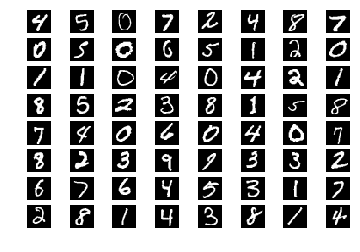

In [11]:
plotter(next(MNISTd)[0:64])

In [23]:
d = next(MNISTd)
d = d.reshape(-1,1,28,28)
# print(d.shape)
vis.images(d[0:45,:,:,:],
          opts=dict(title='Random!', caption='How random.'),)

'window_35ca4b20712fdc'

In [10]:
#pretraining
E = Encoder().cuda()
D = Decoder().cuda()
E = E.double()
D = D.double()
E.apply(wt_init)
D.apply(wt_init)
print(E)
print(D)

Encoder (
  (L1): Linear (784 -> 512)
  (Ou): Linear (512 -> 100)
  (L3): Linear (100 -> 100)
  (L4): Linear (100 -> 100)
)
Decoder (
  (L1): Linear (100 -> 512)
  (Ou): Linear (512 -> 784)
)


In [42]:
list(E.parameters())+ list(D.parameters())

[Parameter containing:
 -1.7827e-02 -1.7806e-02 -5.9077e-03  ...  -2.1912e-02 -5.8538e-03 -1.0049e-02
 -2.1709e-02  4.7425e-02 -9.5942e-04  ...   9.5575e-03  1.2265e-02 -1.1661e-02
 -1.8080e-02  3.8126e-03 -1.7482e-03  ...  -2.3244e-03  1.3635e-02  6.2563e-02
                 ...                   ⋱                   ...                
 -3.3585e-03  1.3208e-02  1.7590e-02  ...  -1.6484e-03  1.8603e-02  7.8758e-03
  3.8834e-02 -5.0585e-02  8.1510e-03  ...   1.9907e-02  1.9622e-02 -1.3050e-02
  1.4259e-02 -4.8798e-03  1.1959e-02  ...  -1.4296e-02 -1.0562e-02  1.6351e-03
 [torch.cuda.DoubleTensor of size 1000x784 (GPU 0)], Parameter containing:
  0
  0
  0
 ⋮ 
  0
  0
  0
 [torch.cuda.DoubleTensor of size 1000 (GPU 0)], Parameter containing:
  1.0972e-02  2.2923e-02 -1.1466e-02  ...  -1.0621e-02  2.3385e-02 -3.1726e-02
 -4.1588e-02 -9.0409e-03  8.5964e-03  ...  -1.8006e-02 -1.6048e-02  2.9407e-02
  1.6162e-02  1.8110e-02  1.6426e-03  ...   2.0850e-02  1.3581e-02  1.2376e-02
             

In [11]:
optim = tchoptim.Adam(list(E.parameters())+ list(D.parameters()), lr=1e-3)

In [12]:
def sample_z(mu, sig):
    e = Variable(tch.randn(BATCHSZ, e_out_dim).cuda().double())
    r = mu + (e*tch.exp(sig/2))
    return r
    

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
randomly chosen 64 generated samples after itr: 0


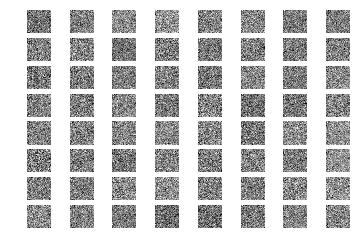

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

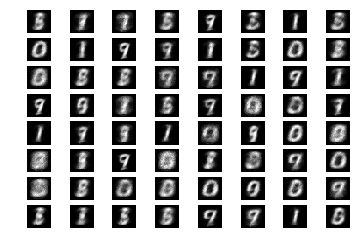

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([1

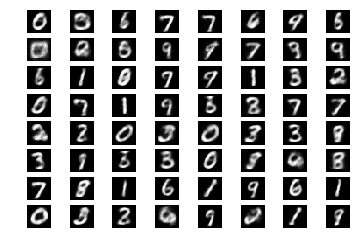

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

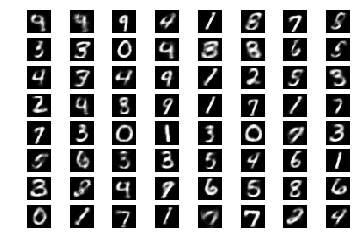

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

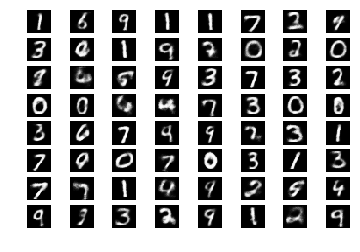

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

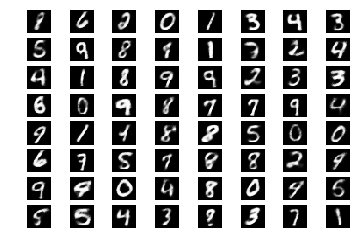

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([1

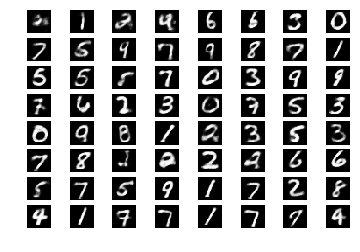

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

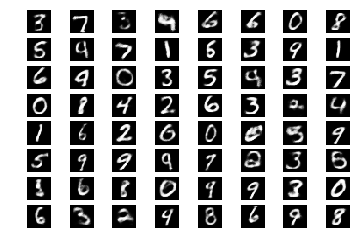

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

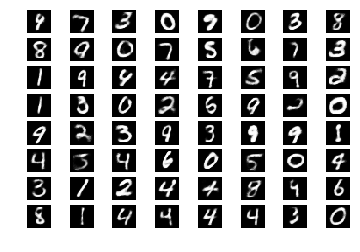

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

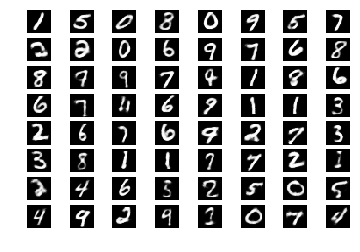

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Size([128, 100])
dbg1
X shape: torch.Size([128, 784])
z_mu shape, z_log_sig shape: torch.Size([128, 100]), torch.Size([128, 100])
z shape: torch.Si

In [19]:
#training
for itr in range(n_iter):
    print('dbg1')
    X = next(MNISTd)
    X = Variable(tch.from_numpy(X).cuda())
    #through the encoder
    E.zero_grad()
    print('X shape: {}'.format(X.size()))
    z_mu, z_log_sig = E(X)
    print('z_mu shape, z_log_sig shape: {}, {}'.format(z_mu.size(), z_log_sig.size()))
    z = sample_z(z_mu, z_log_sig)
    print('z shape: {}'.format(z.size()))
    #through the decoder
    z = z.cuda()
    D.zero_grad()
    d_out = D(z)
    #loss
    recon_loss = F.binary_cross_entropy(d_out, X)
    KL_div = tch.mean(0.5 * tch.sum(tch.exp(z_log_sig) + z_mu**2 - 1. - z_log_sig, 1))
    KL_div /= BATCHSZ*28*28 # <- learnt a lesson, constansdo matter, kind of like units
    loss = recon_loss + KL_div

    loss.backward()
    optim.step()

    #print results sometimes
    if itr%100 == 0:
        #print('64 generated samples after itr: {}'.format(itr))
        print('randomly chosen 64 generated samples after itr: {}'.format(itr))
        d = d_out.data.cpu().numpy()[0:64,:]
        d = d.reshape(-1,1,28,28)
        d1 = list(d)
        d1 = random.sample(d1, 64)
        d = np.array(d1)
        plotter(d) 

ztest shape: torch.Size([1, 100])
y size: torch.Size([1, 784])


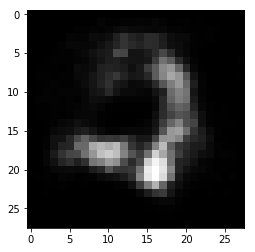

In [48]:
z_test = tch.randn(1,d_inp_dim)
z_test = Variable(z_test.view(-1, d_inp_dim).double().cuda())
print('ztest shape: {}'.format(z_test.size()))
y = D(z_test)
print('y size: {}'.format(y.size()))
y1 = y.data.cpu().numpy().reshape(-1,28,28)
plt.imshow(y1[0,:,:], cmap='gray', interpolation='none')
plt.show()

In [49]:
tch.save(E, './E1.pth')
tch.save(D, './D1.pth')

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/udion/Misc/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [52]:
T = tch.load('./D1.pth')

In [54]:
T(z_test)

Variable containing:

Columns 0 to 9 
 0.0011  0.0008  0.0006  0.0011  0.0006  0.0009  0.0006  0.0008  0.0008  0.0006

Columns 10 to 19 
 0.0008  0.0016  0.0008  0.0013  0.0005  0.0017  0.0007  0.0007  0.0006  0.0011

Columns 20 to 29 
 0.0006  0.0009  0.0006  0.0009  0.0008  0.0008  0.0007  0.0007  0.0010  0.0017

Columns 30 to 39 
 0.0004  0.0006  0.0013  0.0007  0.0023  0.0047  0.0045  0.0180  0.0082  0.0071

Columns 40 to 49 
 0.0137  0.0118  0.0189  0.0168  0.0270  0.0109  0.0064  0.0045  0.0103  0.0024

Columns 50 to 59 
 0.0037  0.0005  0.0005  0.0013  0.0011  0.0010  0.0007  0.0005  0.0008  0.0006

Columns 60 to 69 
 0.0016  0.0006  0.0089  0.0080  0.0144  0.0134  0.0214  0.0387  0.0507  0.0373

Columns 70 to 79 
 0.0347  0.0310  0.0266  0.0296  0.0173  0.0161  0.0102  0.0057  0.0062  0.0079

Columns 80 to 89 
 0.0046  0.0008  0.0006  0.0010  0.0005  0.0007  0.0009  0.0027  0.0018  0.0206

Columns 90 to 99 
 0.0155  0.0146  0.0445  0.0383  0.0534  0.1158  0.1810  0.1356  0.1074